# Sentiment Classification for IMDB Movie Reviews


In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from numpy import array
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalMaxPooling1D, Conv1D, SimpleRNN, LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer

## Loading the Data

You will need to load the reviews. These are provided in the zip.
In addition, you will use pretrained embeddings (GloVe, 100d) which you need to download e.g. from https://nlp.stanford.edu/projects/glove/ .

In [2]:
movie_reviews = pd.read_csv("imdb_data/IMDB Dataset.csv")
movie_reviews.isnull().values.any()
movie_reviews.shape

(50000, 2)

In [3]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

<AxesSubplot:xlabel='sentiment', ylabel='count'>

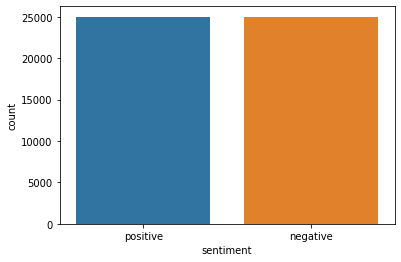

In [5]:
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)


## Preprocessing

__Prepare the review content__:

Remove 
* html tags
* replace punctuation with a space
* remove single characters
* remove multiple spaces

Split into train/test.

Tokenize the reviews - i.e. mapping the words to integers by using a vocabulary of the most frequent words.

Cut and pad the sequences to a given fixed length.

In [6]:
num_words = 5000
maxlen = 100

In [7]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [8]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence


In [9]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

Now the above sample review looks as follows - e.g. in teh first sentence, "there's a zombie" is replaced by just "there a zombie"

In [10]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

__Prepare the labels__

In [11]:
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

__Split into train/test__

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

__Tokenize__

In [13]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [14]:
vocab_size = len(tokenizer.word_index) + 1
print("Tokenizer has found %i words. When transforming texts to sequences words that have an index above %i are just ignored."%(vocab_size, num_words))

Tokenizer has found 92547 words. When transforming texts to sequences words that have an index above 5000 are just ignored.


In [19]:
indices = [0,1,2,3,4,5,6,4999,5000,10000]
for word, index in tokenizer.word_index.items():
    if index in indices:
        print("%s : %i"%(word,index))

the : 1
and : 2
of : 3
to : 4
is : 5
it : 6
secretly : 4999
joins : 5000
shattering : 10000


In [20]:
tokenizer.texts_to_sequences(["This is %s."%tokenizer.index_word[10000]])

[[8, 5]]

__Cutting and Padding__

In [21]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

### Utility

In [22]:
def performance_plots(model, X_test, Y_test, log, epochs):    
    acc = log.history['accuracy']
    val_acc = log.history['val_accuracy']
    print('Train accuracy (end):', acc[-1])
    print('Train accuracy (max):', np.max(acc))
    print('Test accuracy (end) :', val_acc[-1])
    print('Test accuracy (max) :', np.max(val_acc))

    plt.plot(log.history['accuracy'])
    plt.plot(log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.axis([0,epochs,0.0,1.0])
    plt.show()

    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.axis([0,epochs,0.0,2.0])
    plt.show()

In [23]:
import sklearn
import pandas as pd
activities = ["neg", "pos"]

def confusion_matrix(model, X_test, Y_test):
    scores = model.predict(X_test)
    predictions = np.round(scores)
    labels = Y_test
    cm = sklearn.metrics.confusion_matrix(labels, predictions)
    df = pd.DataFrame({activities[i] : cm[:,i] for i in range(len(activities))}, activities)
    return df

## A First Simple Model: Just an embedding layer and a dense layer 

In [30]:
# START YOUR CODE

nepochs = 10
embedding_dim = 32 
batchsize = 32


model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(maxlen)),
    tf.keras.layers.Embedding(input_dim=num_words, output_dim=32),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics="accuracy")


# END YOUR CODE

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 32)           160000    
_________________________________________________________________
flatten_3 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3201      
Total params: 163,201
Trainable params: 163,201
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.4232 - accuracy: 0.7995 - val_loss: 0.3155 - val_accuracy: 0.8610
Epoch 2/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2684 - accuracy: 0.8895 - val_loss: 0.3146 - val_accuracy: 0.8640
Epoch 3/10
1250/1250 [==============================] - 10s 8ms/step - loss: 0.1932 - accuracy: 0.9295 - val_loss: 0.3337 - val_accuracy: 0.8566
Epoch 4/10
1250/1250 [==============================] - 2s 2ms/step - loss: 0.1124 - accuracy: 0.9712 - val_loss: 0.3679 - val_accuracy: 0.8531
Epoch 5/10
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0556 - accuracy: 0.9925 - val_loss: 0.4141 - val_accuracy: 0.8460
Epoch 6/10
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0250 - accuracy: 0.9984 - val_loss: 0.4623 - val_accuracy: 0.8463
Epoch 7/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.0112 - accuracy: 0.9998 - val_loss: 0.5112 - val_accuracy

Train accuracy (end): 1.0
Train accuracy (max): 1.0
Test accuracy (end) : 0.8468999862670898
Test accuracy (max) : 0.8640000224113464


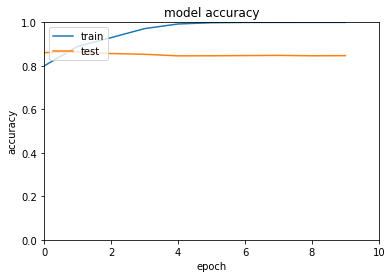

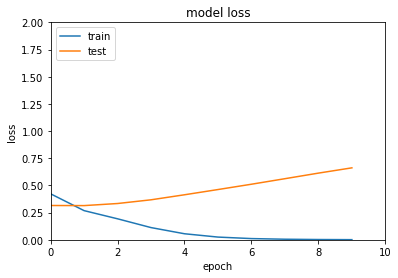

,neg,pos
neg,4149,812
pos,719,4320


In [32]:
performance_plots(model, X_test, y_test, history, nepochs)
confusion_matrix(model, X_test, y_test)

We easily get into the overfitting regime since we have a huge amount of parameters.

## Using GloVe as pretrained embedding

In [35]:
embeddings_dictionary = dict()
glove_file = open('../glove.6B.50d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [38]:
embedding_matrix = np.zeros((num_words, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None and index<num_words:
        embedding_matrix[index] = embedding_vector

In [49]:
# START YOUR CODE
nepochs = 10
embedding_dim = 50 
batchsize = 32
embedding_layer = tf.keras.layers.Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=False)

model = Sequential([
    tf.keras.layers.Input(shape=(maxlen)),
    embedding_layer,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# START YOUR CODE

model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics="accuracy")

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 50)           250000    
_________________________________________________________________
flatten_9 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 5001      
Total params: 255,001
Trainable params: 5,001
Non-trainable params: 250,000
_________________________________________________________________


In [50]:
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
1250/1250 [==============================] - 1s 1ms/step - loss: 0.6030 - accuracy: 0.6776 - val_loss: 0.5658 - val_accuracy: 0.7156
Epoch 2/10
1250/1250 [==============================] - 1s 1ms/step - loss: 0.5432 - accuracy: 0.7299 - val_loss: 0.5992 - val_accuracy: 0.7023
Epoch 3/10
1250/1250 [==============================] - 1s 1ms/step - loss: 0.5343 - accuracy: 0.7367 - val_loss: 0.5752 - val_accuracy: 0.7149
Epoch 4/10
1250/1250 [==============================] - 1s 1ms/step - loss: 0.5292 - accuracy: 0.7443 - val_loss: 0.6010 - val_accuracy: 0.7053
Epoch 5/10
1250/1250 [==============================] - 1s 1ms/step - loss: 0.5273 - accuracy: 0.7462 - val_loss: 0.5834 - val_accuracy: 0.7188
Epoch 6/10
1250/1250 [==============================] - 1s 1ms/step - loss: 0.5244 - accuracy: 0.7494 - val_loss: 0.6043 - val_accuracy: 0.7052
Epoch 7/10
1250/1250 [==============================] - 1s 1ms/step - loss: 0.5269 - accuracy: 0.7459 - val_loss: 0.5933 - val_accuracy:

Train accuracy (end): 0.7512249946594238
Train accuracy (max): 0.7523750066757202
Test accuracy (end) : 0.7103000283241272
Test accuracy (max) : 0.7188000082969666


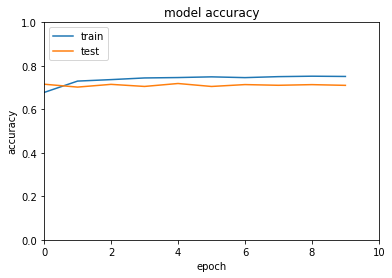

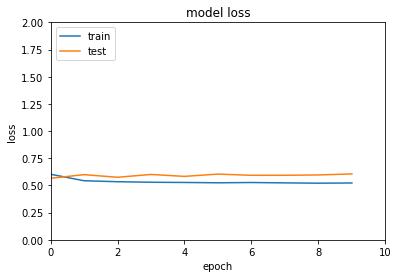

,neg,pos
neg,3841,1120
pos,1777,3262


In [51]:
performance_plots(model, X_test, y_test, history, nepochs)
confusion_matrix(model, X_test, y_test)

We no longer observe an as high variance as before, but the model now also suffers from high bias.

## Further Model / Hyper Parameter Combinations

Examples:

* Pretrained embedding (with GloVe), possibly fine-tuned
* dito + (SimpleRNN | LSTM | GRU | Conv1D)
* dito + stacked layers

For each combination, specify a cell with the model specification, one with the training and one with the evaluation (use for the latter the utilities provided).  


# Finetuned GloVe

In [52]:
# START YOUR CODE
nepochs = 10
embedding_dim = 50 
batchsize = 32
embedding_layer = tf.keras.layers.Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=True)

model = Sequential([
    tf.keras.layers.Input(shape=(maxlen)),
    embedding_layer,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# START YOUR CODE

model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics="accuracy")

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 50)           250000    
_________________________________________________________________
flatten_10 (Flatten)         (None, 5000)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 5001      
Total params: 255,001
Trainable params: 255,001
Non-trainable params: 0
_________________________________________________________________


In [53]:
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
1250/1250 [==============================] - 3s 3ms/step - loss: 0.5007 - accuracy: 0.7487 - val_loss: 0.3984 - val_accuracy: 0.8157
Epoch 2/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.3236 - accuracy: 0.8598 - val_loss: 0.3580 - val_accuracy: 0.8383
Epoch 3/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2520 - accuracy: 0.8966 - val_loss: 0.3770 - val_accuracy: 0.8371
Epoch 4/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.1927 - accuracy: 0.9266 - val_loss: 0.3962 - val_accuracy: 0.8385
Epoch 5/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.1357 - accuracy: 0.9539 - val_loss: 0.4237 - val_accuracy: 0.8343
Epoch 6/10
1250/1250 [==============================] - 10s 8ms/step - loss: 0.0869 - accuracy: 0.9768 - val_loss: 0.4804 - val_accuracy: 0.8329ccu - ETA: 3s - loss: 0.085
Epoch 7/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.0493 - accuracy: 0.9912 - val_

Train accuracy (end): 0.9998250007629395
Train accuracy (max): 0.9998250007629395
Test accuracy (end) : 0.8291000127792358
Test accuracy (max) : 0.8385000228881836


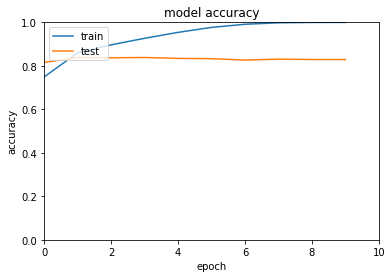

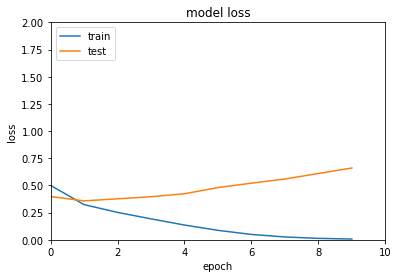

,neg,pos
neg,4064,897
pos,812,4227


In [54]:
performance_plots(model, X_test, y_test, history, nepochs)
confusion_matrix(model, X_test, y_test)

The bias seems to be gone, but the variance increased even a little more than when using a random embedding initialization.

# SimpleRNN

In [57]:
# START YOUR CODE
nepochs = 10
embedding_dim = 50 
batchsize = 32
embedding_layer = tf.keras.layers.Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=False)

model = Sequential([
    tf.keras.layers.Input(shape=(maxlen)),
    embedding_layer,
    tf.keras.layers.SimpleRNN(units=256),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# START YOUR CODE

model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics="accuracy")

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 50)           250000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 256)               78592     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 328,849
Trainable params: 78,849
Non-trainable params: 250,000
_________________________________________________________________


In [58]:
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
1250/1250 [==============================] - 88s 71ms/step - loss: 0.6964 - accuracy: 0.5268 - val_loss: 0.6832 - val_accuracy: 0.5422
Epoch 2/10
1250/1250 [==============================] - 94s 75ms/step - loss: 0.6805 - accuracy: 0.5557 - val_loss: 0.6833 - val_accuracy: 0.5568
Epoch 3/10
1250/1250 [==============================] - 109s 87ms/step - loss: 0.6711 - accuracy: 0.5812 - val_loss: 0.6684 - val_accuracy: 0.5915
Epoch 4/10
1250/1250 [==============================] - 99s 79ms/step - loss: 0.6591 - accuracy: 0.6079 - val_loss: 0.6046 - val_accuracy: 0.6879
Epoch 5/10
1250/1250 [==============================] - 150s 120ms/step - loss: 0.6644 - accuracy: 0.5953 - val_loss: 0.6537 - val_accuracy: 0.6176
Epoch 6/10
1250/1250 [==============================] - 221s 177ms/step - loss: 0.6672 - accuracy: 0.5993 - val_loss: 0.6897 - val_accuracy: 0.5158
Epoch 7/10
1250/1250 [==============================] - 223s 178ms/step - loss: 0.6725 - accuracy: 0.5760 - val_loss: 0

Train accuracy (end): 0.6485999822616577
Train accuracy (max): 0.6485999822616577
Test accuracy (end) : 0.6823999881744385
Test accuracy (max) : 0.6879000067710876


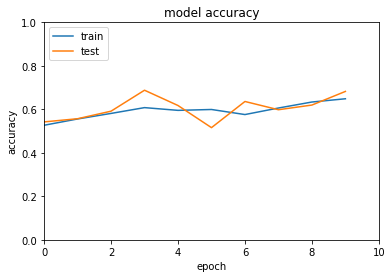

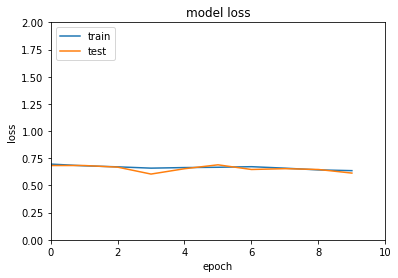

,neg,pos
neg,3187,1774
pos,1402,3637


In [59]:
performance_plots(model, X_test, y_test, history, nepochs)
confusion_matrix(model, X_test, y_test)

# LSTM

In [60]:
# START YOUR CODE
nepochs = 10
embedding_dim = 50 
batchsize = 32
embedding_layer = tf.keras.layers.Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=True)

model = Sequential([
    tf.keras.layers.Input(shape=(maxlen)),
    embedding_layer,
    tf.keras.layers.LSTM(units=256),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# START YOUR CODE

model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics="accuracy")

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 50)           250000    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               314368    
_________________________________________________________________
flatten_11 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 564,625
Trainable params: 564,625
Non-trainable params: 0
_________________________________________________________________


In [61]:
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
1250/1250 [==============================] - 940s 752ms/step - loss: 0.4896 - accuracy: 0.7652 - val_loss: 0.3963 - val_accuracy: 0.8222
Epoch 2/10
1250/1250 [==============================] - 816s 653ms/step - loss: 0.3310 - accuracy: 0.8600 - val_loss: 0.3224 - val_accuracy: 0.8638
Epoch 3/10
1250/1250 [==============================] - 613s 490ms/step - loss: 0.2772 - accuracy: 0.8855 - val_loss: 0.2983 - val_accuracy: 0.8719
Epoch 4/10
1250/1250 [==============================] - 704s 563ms/step - loss: 0.2520 - accuracy: 0.8993 - val_loss: 0.2901 - val_accuracy: 0.8760
Epoch 5/10
1250/1250 [==============================] - 705s 564ms/step - loss: 0.2276 - accuracy: 0.9103 - val_loss: 0.3025 - val_accuracy: 0.8721
Epoch 6/10
1250/1250 [==============================] - 703s 562ms/step - loss: 0.1979 - accuracy: 0.9239 - val_loss: 0.3079 - val_accuracy: 0.8752
Epoch 7/10
1250/1250 [==============================] - 575s 460ms/step - loss: 0.1827 - accuracy: 0.9320 - val_

Train accuracy (end): 0.9700750112533569
Train accuracy (max): 0.9700750112533569
Test accuracy (end) : 0.8605999946594238
Test accuracy (max) : 0.8759999871253967


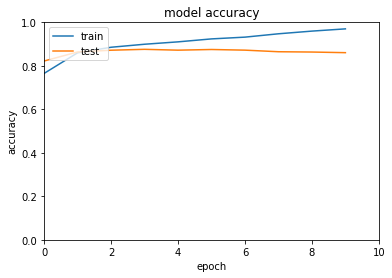

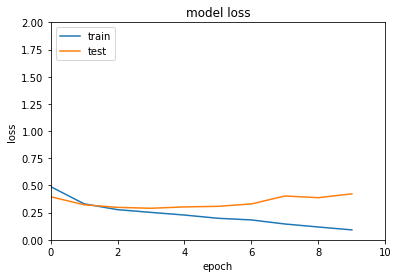

,neg,pos
neg,4147,814
pos,580,4459


In [62]:
performance_plots(model, X_test, y_test, history, nepochs)
confusion_matrix(model, X_test, y_test)

# GRU

In [63]:
# START YOUR CODE
nepochs = 10
embedding_dim = 50 
batchsize = 32
embedding_layer = tf.keras.layers.Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=True)

model = Sequential([
    tf.keras.layers.Input(shape=(maxlen)),
    embedding_layer,
    tf.keras.layers.GRU(units=256),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# START YOUR CODE

model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics="accuracy")

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 50)           250000    
_________________________________________________________________
gru (GRU)                    (None, 256)               236544    
_________________________________________________________________
flatten_12 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 486,801
Trainable params: 486,801
Non-trainable params: 0
_________________________________________________________________


In [64]:
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
1250/1250 [==============================] - 398s 318ms/step - loss: 0.4184 - accuracy: 0.8034 - val_loss: 0.3302 - val_accuracy: 0.8551
Epoch 2/10
1250/1250 [==============================] - 386s 309ms/step - loss: 0.2851 - accuracy: 0.8790 - val_loss: 0.2847 - val_accuracy: 0.8759
Epoch 3/10
1250/1250 [==============================] - 393s 315ms/step - loss: 0.2410 - accuracy: 0.9033 - val_loss: 0.2870 - val_accuracy: 0.8777
Epoch 4/10
1250/1250 [==============================] - 401s 321ms/step - loss: 0.2028 - accuracy: 0.9204 - val_loss: 0.3018 - val_accuracy: 0.8758
Epoch 5/10
1250/1250 [==============================] - 402s 322ms/step - loss: 0.1564 - accuracy: 0.9417 - val_loss: 0.3446 - val_accuracy: 0.8744
Epoch 6/10
1250/1250 [==============================] - 399s 319ms/step - loss: 0.1050 - accuracy: 0.9629 - val_loss: 0.4151 - val_accuracy: 0.8640
Epoch 7/10
1250/1250 [==============================] - 400s 320ms/step - loss: 0.0625 - accuracy: 0.9800 - val_

Train accuracy (end): 0.9941250085830688
Train accuracy (max): 0.9941250085830688
Test accuracy (end) : 0.8601999878883362
Test accuracy (max) : 0.8776999711990356


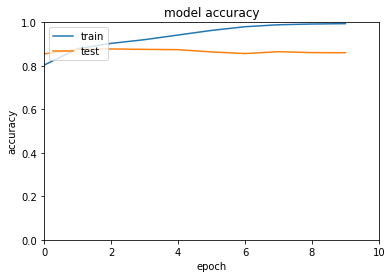

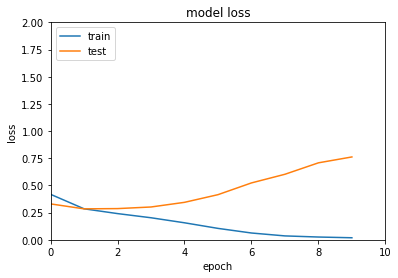

,neg,pos
neg,4264,697
pos,701,4338


In [65]:
performance_plots(model, X_test, y_test, history, nepochs)
confusion_matrix(model, X_test, y_test)

# Conv1D

In [66]:
# START YOUR CODE
nepochs = 10
embedding_dim = 50 
batchsize = 32
embedding_layer = tf.keras.layers.Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=True)

model = Sequential([
    tf.keras.layers.Input(shape=(maxlen)),
    embedding_layer,
    tf.keras.layers.Conv1D(kernel_size=3, filters=32),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# START YOUR CODE

model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics="accuracy")

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 100, 50)           250000    
_________________________________________________________________
conv1d (Conv1D)              (None, 98, 32)            4832      
_________________________________________________________________
flatten_13 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 3137      
Total params: 257,969
Trainable params: 257,969
Non-trainable params: 0
_________________________________________________________________


In [67]:
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.4859 - accuracy: 0.7586 - val_loss: 0.3717 - val_accuracy: 0.8354
Epoch 2/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.3175 - accuracy: 0.8650 - val_loss: 0.3494 - val_accuracy: 0.8425
Epoch 3/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.0059 - accuracy: 0.9989 - val_loss: 1.1359 - val_accuracy: 0.8251


Train accuracy (end): 0.9988999962806702
Train accuracy (max): 0.9988999962806702
Test accuracy (end) : 0.8251000046730042
Test accuracy (max) : 0.8424999713897705


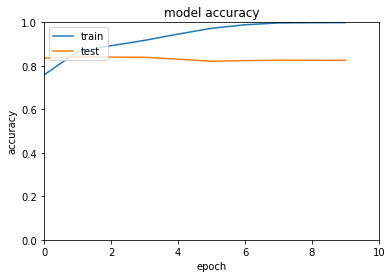

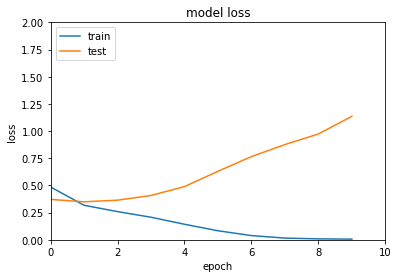

,neg,pos
neg,4194,767
pos,982,4057


In [68]:
performance_plots(model, X_test, y_test, history, nepochs)
confusion_matrix(model, X_test, y_test)

# Conv2D

In [69]:
# START YOUR CODE
nepochs = 10
embedding_dim = 50 
batchsize = 32
embedding_layer = tf.keras.layers.Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=True)

model = Sequential([
    tf.keras.layers.Input(shape=(maxlen)),
    embedding_layer,
    tf.keras.layers.Reshape((maxlen, embedding_dim, 1)),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# START YOUR CODE

model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics="accuracy")

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 100, 50)           250000    
_________________________________________________________________
reshape (Reshape)            (None, 100, 50, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 46, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 21, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 19, 64)      

In [70]:
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
1250/1250 [==============================] - 873s 698ms/step - loss: 0.4788 - accuracy: 0.7551 - val_loss: 0.3621 - val_accuracy: 0.8374
Epoch 2/10
1250/1250 [==============================] - 895s 716ms/step - loss: 0.3288 - accuracy: 0.8594 - val_loss: 0.3417 - val_accuracy: 0.8464
Epoch 3/10
1250/1250 [==============================] - 1344s 1s/step - loss: 0.2732 - accuracy: 0.8867 - val_loss: 0.3815 - val_accuracy: 0.8452
Epoch 4/10
1250/1250 [==============================] - 1176s 941ms/step - loss: 0.2126 - accuracy: 0.9150 - val_loss: 0.4596 - val_accuracy: 0.8263
Epoch 5/10
1250/1250 [==============================] - 1073s 858ms/step - loss: 0.1532 - accuracy: 0.9396 - val_loss: 0.5108 - val_accuracy: 0.8325
Epoch 6/10
1250/1250 [==============================] - 1008s 807ms/step - loss: 0.1026 - accuracy: 0.9606 - val_loss: 0.7390 - val_accuracy: 0.8274
Epoch 7/10
1250/1250 [==============================] - 1000s 800ms/step - loss: 0.0798 - accuracy: 0.9706 - va

Train accuracy (end): 0.9796749949455261
Train accuracy (max): 0.9796749949455261
Test accuracy (end) : 0.8276000022888184
Test accuracy (max) : 0.8464000225067139


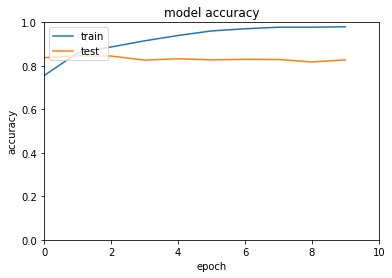

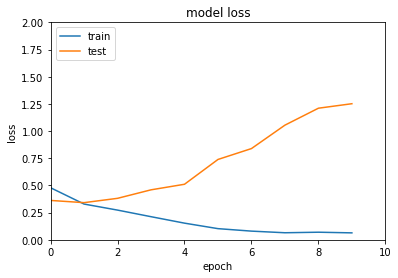

,neg,pos
neg,4047,914
pos,810,4229


In [71]:
performance_plots(model, X_test, y_test, history, nepochs)
confusion_matrix(model, X_test, y_test)

## Report with your Findings

The best accuracy is achieved by a GRU RNN with 87.7% on the test set. A very similar score is achieved by the LSTM architecture with 87.4%. Both networks use the pretrained Glove embedding matrix and are allowed to fine tune it durring training. In this exercise the benefit of the LSTM / GRU architecture over the SimpleRNN is clearly visible with a difference of ~20% in terms of test accuracy!

The CNN architectures reach comparable scores, but clearly worse with 84.6% at best.